### Libraries

In [4]:
library(tuneR)
library(signal)
library(seewave)
library(wavelets)
library(lintr)
library(ggplot2)
library(plotly)
library(Rtsne)
library(pracma)
library(fields)
library(soundgen)
library(viridisLite)
library(stats)
library(fields)
library(dplyr)


# Loading wav files

In [5]:
setwd("/home/baptiste/MASTER1/S2/DataMining/project/")


[1] "./data/Propagation_experiments/individuals_propagation/100_m/K_segment_11_100m.wav"
[1] "./data/Propagation_experiments/individuals_propagation/100_m/K_segment_12_100m.wav"
[1] "./data/Propagation_experiments/individuals_propagation/100_m/K_segment_13_100m.wav"
[1] "./data/Propagation_experiments/individuals_propagation/100_m/K_segment_14_100m.wav"
[1] "./data/Propagation_experiments/individuals_propagation/100_m/K_segment_15_100m.wav"
[1] "./data/Propagation_experiments/individuals_propagation/100_m/K_segment_16_100m.wav"
[1] "./data/Propagation_experiments/individuals_propagation/100_m/K_segment_17_100m.wav"
[1] "./data/Propagation_experiments/individuals_propagation/100_m/K_segment_18_100m.wav"
[1] "./data/Propagation_experiments/individuals_propagation/100_m/K_segment_19_100m.wav"
[1] "./data/Propagation_experiments/individuals_propagation/100_m/K_segment_20_100m.wav"
[1] "./data/Propagation_experiments/individuals_propagation/100_m/L_segment_21_100m.wav"
[1] "./data/Propagati

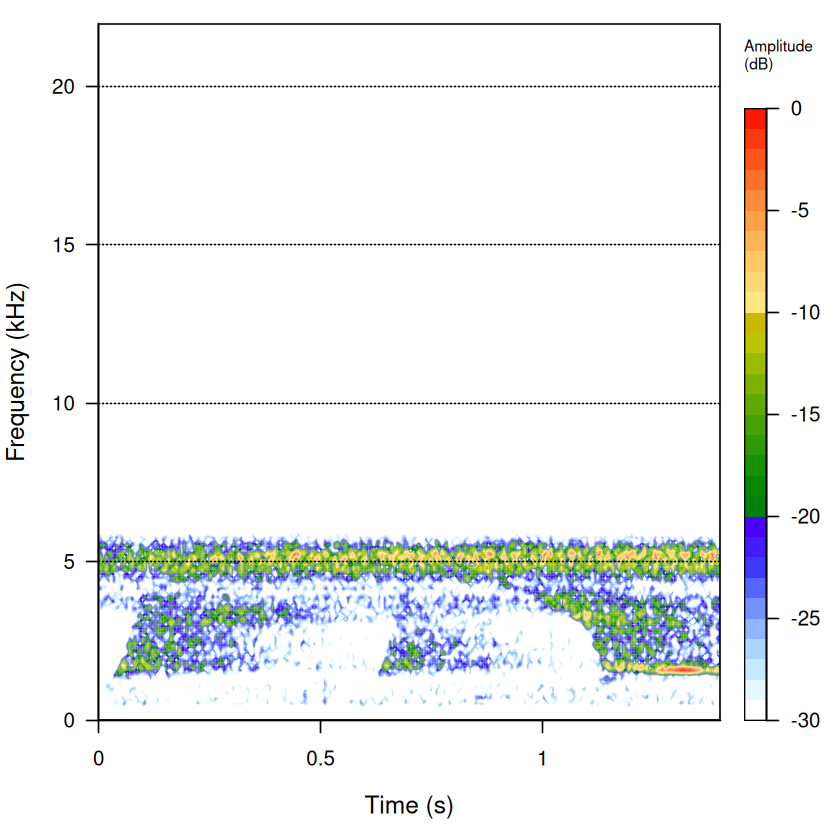

In [23]:
load_wav_files <- function(path = "./data/Propagation_experiments/individuals_propagation", pattern = "*.wav") {
  files <- list.files(path = path, pattern = pattern, full.names = TRUE, recursive = TRUE)
  audio_list <- list()

  for (file in files) {
    audio <- readWave(file)
    print(file)
    if (audio@stereo) {
      audio <- mono(audio, which = "left")
    }
    audio_list[[file]] <- audio
  }
  print("Files loaded.")
  return(audio_list)
}

audio_list <- load_wav_files()

audio <- audio_list[[1]]
sr <- audio@samp.rate
spec <- spectro(audio, plot = TRUE, f = sr, ovlp = 50, wl = 512)
freq_bins <- nrow(spec$amp)
time_bins <- ncol(spec$amp)
print(freq_bins)
print(time_bins)


[1] "./data/Propagation_experiments/noise_propagation/noise_100_m/K_noise_11_100m.wav"
[1] "./data/Propagation_experiments/noise_propagation/noise_100_m/K_noise_12_100m.wav"
[1] "./data/Propagation_experiments/noise_propagation/noise_100_m/K_noise_13_100m.wav"
[1] "./data/Propagation_experiments/noise_propagation/noise_100_m/K_noise_14_100m.wav"
[1] "./data/Propagation_experiments/noise_propagation/noise_100_m/K_noise_15_100m.wav"
[1] "./data/Propagation_experiments/noise_propagation/noise_100_m/K_noise_16_100m.wav"
[1] "./data/Propagation_experiments/noise_propagation/noise_100_m/K_noise_17_100m.wav"
[1] "./data/Propagation_experiments/noise_propagation/noise_100_m/K_noise_18_100m.wav"
[1] "./data/Propagation_experiments/noise_propagation/noise_100_m/K_noise_19_100m.wav"
[1] "./data/Propagation_experiments/noise_propagation/noise_100_m/K_noise_20_100m.wav"
[1] "./data/Propagation_experiments/noise_propagation/noise_100_m/L_noise_21_100m.wav"
[1] "./data/Propagation_experiments/noise_p

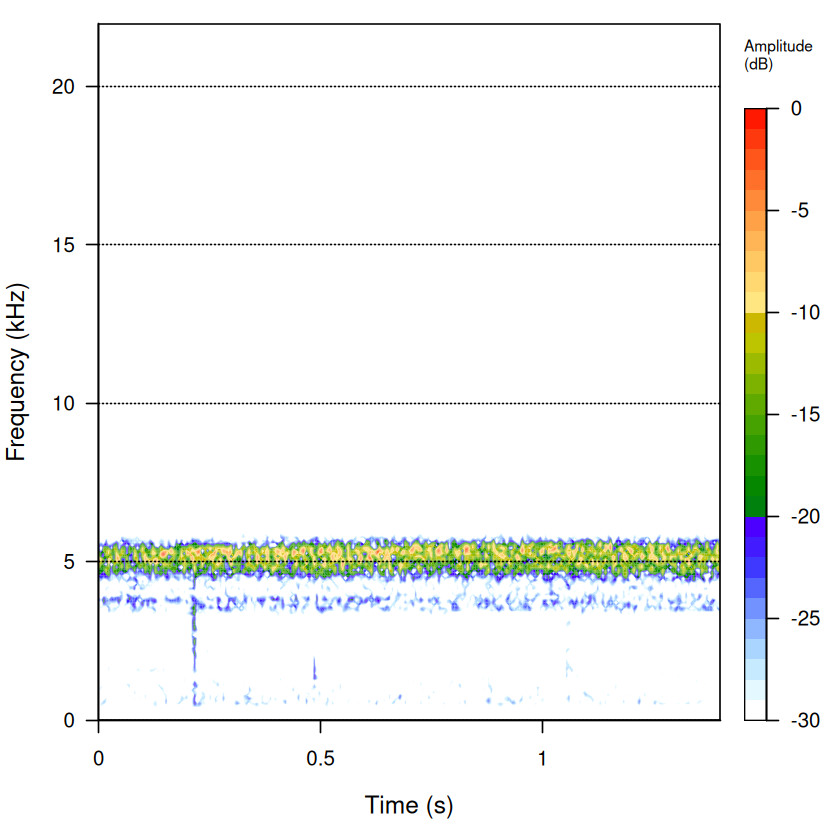

In [53]:
noise_list <- load_wav_files(path = "./data/Propagation_experiments/noise_propagation")

noise <- noise_list[[1]]
sr <- noise@samp.rate
spec <- spectro(noise, plot = TRUE, f = sr, ovlp = 50, wl = 512)
noise_freq_bins <- nrow(spec$amp)
noise_time_bins <- ncol(spec$amp)
print(noise_freq_bins)
print(noise_time_bins)



# Extracting features

In [24]:
process_audio_list <- function(audio_list) {
  data_list <- list()

  for (file in names(audio_list)) {
    audio <- audio_list[[file]]
    sr <- audio@samp.rate

    spec <- spectro(audio, f = sr, plot = FALSE, ovlp = 50, wl = 512)

    spec_matrix <- spec$amp

    # Extract the label
    file_name <- basename(file)
    parts <- unlist(strsplit(file_name, "_"))
    individual <- parts[1]
    distance <- sub("\\m.wav$", "", parts[length(parts)])

    # Store the spectro
    data_list[[file]] <- c(spec_matrix, individual, distance)
  }

  df <- as.data.frame(do.call(rbind, data_list))
  
  # Add the column names for the spectrogram features + the labels
  num_spec_features <- length(as.vector(spec_matrix))
  colnames(df) <- c(paste0("SpecFeature", 1:num_spec_features), "Individual", "Distance")

  df[, 1:num_spec_features] <- lapply(df[, 1:num_spec_features], as.numeric)
  
  return(df)
}


### Loading and saving into a dataframe

In [56]:
df <- process_audio_list(audio_list)


In [ ]:
noise_df <- process_audio_list(noise_list)


In [58]:
df$Type <- "Signal"
noise_df$Type <- "Noise"

combined_df <- rbind(df, noise_df)
saveRDS(combined_df, "./data/Propagation_experiments/df.rds")


In [6]:
combined_df <- readRDS("./data/Propagation_experiments/df.rds")


In [7]:
spec_features <- as.matrix(combined_df[, 1:(ncol(combined_df) - 3)])
pca_result <- prcomp(spec_features, center = TRUE, scale. = TRUE)

summary(pca_result)


Importance of components:
                            PC1      PC2      PC3      PC4      PC5      PC6
Standard deviation     205.1242 47.26465 28.67194 17.50446 14.11191 13.54303
Proportion of Variance   0.6848  0.03636  0.01338  0.00499  0.00324  0.00299
Cumulative Proportion    0.6848  0.72119  0.73457  0.73956  0.74280  0.74578
                            PC7     PC8     PC9    PC10    PC11    PC12    PC13
Standard deviation     11.25469 9.30727 9.20114 8.35094 7.81707 7.37344 7.25321
Proportion of Variance  0.00206 0.00141 0.00138 0.00114 0.00099 0.00088 0.00086
Cumulative Proportion   0.74784 0.74925 0.75063 0.75177 0.75276 0.75365 0.75450
                          PC14    PC15    PC16    PC17    PC18    PC19    PC20
Standard deviation     7.10747 7.03390 6.93903 6.71908 6.44586 6.27533 6.12307
Proportion of Variance 0.00082 0.00081 0.00078 0.00073 0.00068 0.00064 0.00061
Cumulative Proportion  0.75533 0.75613 0.75691 0.75765 0.75833 0.75897 0.75958
                          PC21

In [16]:
plot_spectro <- function(spec_features){
  freq_bins <- 256
  time_bins <- 240
  spec_matrix <- matrix(as.numeric(spec_features), nrow = freq_bins, ncol = time_bins)

  custom_palette <- colorRampPalette(c("black", "blue", "cyan", "yellow", "red"))(100)

  image.plot(
    x = 1:time_bins,
    y = 1:freq_bins,
    z = t(spec_matrix),
    col = custom_palette,
    xlab = "Time",
    ylab = "Frequency",
    main = "Spectrogram",
    legend.lab = "Amplitude (dB)",
    legend.cex = 1
  )
}

plot_reconstructed_spectro <- function(reconstructed_features, num_components){
  # Reshape the reconstructed data
  freq_bins <- 256
  time_bins <- 240
  reconstructed_matrix <- matrix(reconstructed_features[1, ], nrow = freq_bins, ncol = time_bins)

  image.plot(
    x = 1:time_bins,
    y = 1:freq_bins,
    z = t(reconstructed_matrix),
    col = colorRampPalette(c("black", "blue", "cyan", "yellow", "red"))(100),
    xlab = "Time",
    ylab = "Frequency",
    main = paste("Reconstructed Spectrogram (Using", num_components, "PCs)"),
    legend.lab = "Amplitude (dB)"
  )
}


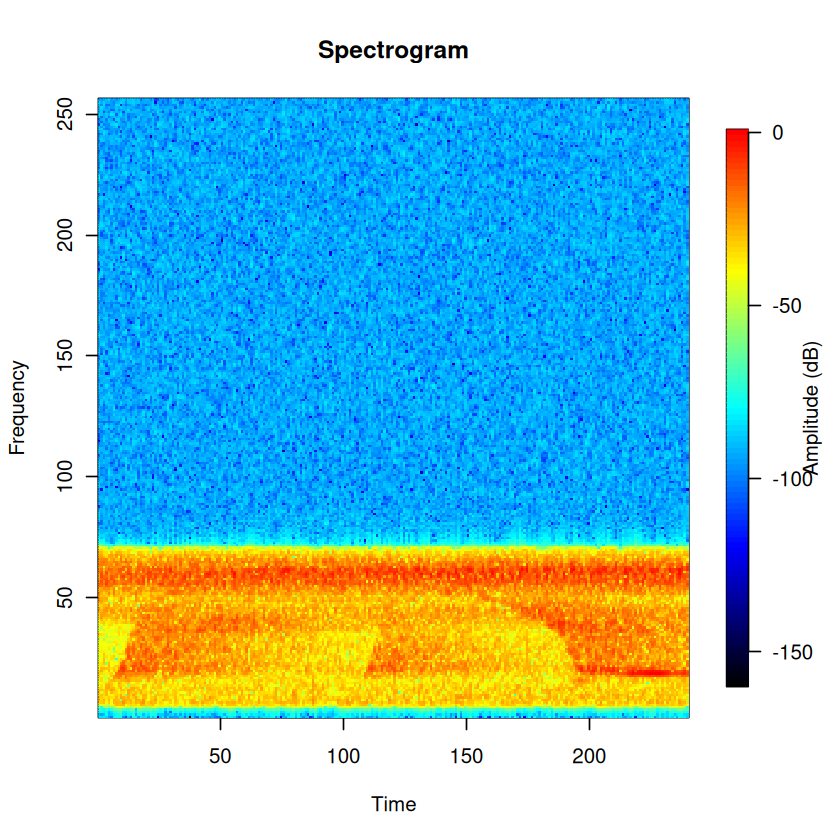

In [17]:
spectrogram <- combined_df[1, ]

spec_features <- spectrogram[1:(ncol(spectrogram) - 3)]

plot_spectro(spec_features)


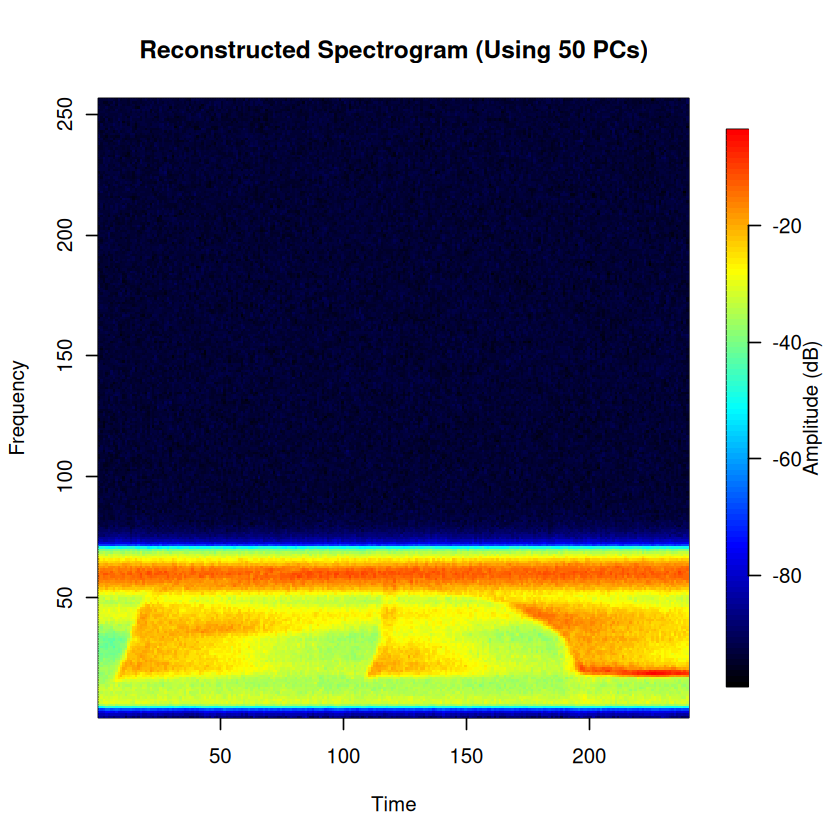

In [21]:
num_components <- 50
pca_components <- pca_result$rotation
pca_scores <- pca_result$x

reconstructed_features <- pca_scores[, 1:num_components] %*% t(pca_components[, 1:num_components])

if (!is.null(pca_result$scale)) {
  reconstructed_features <- scale(reconstructed_features, center = FALSE, scale = 1 / pca_result$scale)
}
if (!is.null(pca_result$center)) {
  reconstructed_features <- scale(reconstructed_features, center = -pca_result$center, scale = FALSE)
}

plot_reconstructed_spectro(reconstructed_features, num_components)


In [8]:
explained_variance <- cumsum(pca_result$sdev^2 / sum(pca_result$sdev^2))
num_components <- which.max(explained_variance >= 0.99999)

num_components


[1] 999

In [9]:
pca_data <- pca_result$x[, 1:num_components]

pca_df <- as.data.frame(pca_data)
pca_df$Individual <- combined_df$Individual
pca_df$Distance <- combined_df$Distance
pca_df$Type <- combined_df$Type

saveRDS(pca_df, file = "./data/Propagation_experiments/df_pca.rds")


In [ ]:

rm(spec_features, df, noise_df, combined_df, pca_result, pca_data)
gc()


# Test

In [57]:
spectrogram_data <- df_12_5 %>% select(starts_with("SpecFeature"))

spectrogram_data <- as.data.frame(lapply(spectrogram_data, normalize))

spectrogram_matrix <- as.matrix(spectrogram_data)


In [58]:
library(reticulate)
library(keras)

use_python("/home/baptiste/MASTER1/S2/DataMining/project/.venv/bin/python", required = TRUE)
py_config()
py_run_string("
import tensorflow as tf
# Set the number of threads for parallelism
tf.config.threading.set_inter_op_parallelism_threads(8)  # Number of CPUs for inter-op parallelism
tf.config.threading.set_intra_op_parallelism_threads(8)  # Number of CPUs for intra-op parallelism
print('TensorFlow version:', tf.__version__)
")
input_shape <- c(ncol(spectrogram_data))

input_layer <- layer_input(shape = input_shape, name = "input")
encoder_1 <- layer_dense(units = 128, activation = "relu", name = "encoder_1")(input_layer)
encoder_2 <- layer_dense(units = 64, activation = "relu", name = "encoder_2")(encoder_1)
encoded <- layer_dense(units = 32, activation = "relu", name = "encoded")(encoder_2)
decoder_1 <- layer_dense(units = 64, activation = "relu", name = "decoder_1")(encoded)
decoder_2 <- layer_dense(units = 128, activation = "relu", name = "decoder_2")(decoder_1)
decoded <- layer_dense(units = input_shape[1], activation = "sigmoid", name = "decoded")(decoder_2)

autoencoder <- keras_model(inputs = input_layer, outputs = decoded)

keras:::compile.keras.engine.training.Model(
  autoencoder,
  optimizer = "adam",
  loss = "mse"
)

summary(autoencoder)


python:         /home/baptiste/MASTER1/S2/DataMining/project/.venv/bin/python
libpython:      /usr/lib/python3.11/config-3.11-x86_64-linux-gnu/libpython3.11.so
pythonhome:     /home/baptiste/MASTER1/S2/DataMining/project/.venv:/home/baptiste/MASTER1/S2/DataMining/project/.venv
version:        3.11.11 (main, Dec  4 2024, 08:55:08) [GCC 13.2.0]
numpy:          /home/baptiste/MASTER1/S2/DataMining/project/.venv/lib/python3.11/site-packages/numpy
numpy_version:  2.0.2
tensorflow:     /home/baptiste/MASTER1/S2/DataMining/project/.venv/lib/python3.11/site-packages/tensorflow

NOTE: Python version was forced by use_python() function

<Functional name=functional_6, built=True>


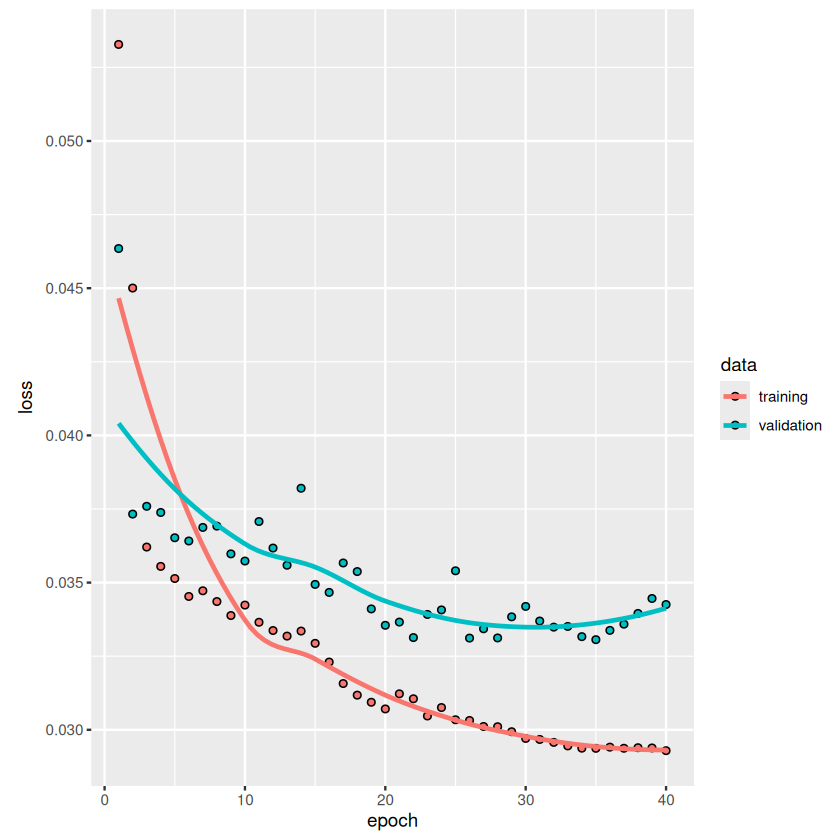

In [59]:
history <- keras:::fit.keras.engine.training.Model(
  autoencoder,
  x = spectrogram_matrix,
  y = spectrogram_matrix,
  epochs = 40,
  batch_size = 32,
  validation_split = 0.2,
  verbose = 1
)

plot(history)


In [60]:
reconstructed_data <- keras:::predict.keras.engine.training.Model(autoencoder, spectrogram_matrix)

encoder_model <- keras_model(inputs = input_layer, outputs = encoded)
latent_data <- keras:::predict.keras.engine.training.Model(encoder_model, spectrogram_matrix)

print("Original data dimensions:")
dim(spectrogram_matrix)
print("Reconstructed data dimensions:")
dim(reconstructed_data)
print("Latent data dimensions:")
dim(latent_data)


[1] "Original data dimensions:"


[1]   100 61440

[1] "Reconstructed data dimensions:"


[1]   100 61440

[1] "Latent data dimensions:"


[1] 100  32

In [61]:
saveRDS(latent_data, "./data/Propagation_experiments/df_autoencoder_12_5.rds")


Performing PCA
Read the 100 x 32 data matrix successfully!
OpenMP is working. 1 threads.
Using no_dims = 2, perplexity = 30.000000, and theta = 0.500000
Computing input similarities...
Building tree...
Done in 0.01 seconds (sparsity = 0.973800)!
Learning embedding...
Iteration 50: error is 46.055130 (50 iterations in 0.02 seconds)
Iteration 100: error is 46.117464 (50 iterations in 0.02 seconds)
Iteration 150: error is 46.026353 (50 iterations in 0.02 seconds)
Iteration 200: error is 47.322430 (50 iterations in 0.02 seconds)
Iteration 250: error is 48.241383 (50 iterations in 0.02 seconds)
Iteration 300: error is 1.157936 (50 iterations in 0.01 seconds)
Iteration 350: error is 0.262618 (50 iterations in 0.01 seconds)
Iteration 400: error is 0.078248 (50 iterations in 0.01 seconds)
Iteration 450: error is 0.048119 (50 iterations in 0.01 seconds)
Iteration 500: error is 0.049350 (50 iterations in 0.01 seconds)
Iteration 550: error is 0.052677 (50 iterations in 0.01 seconds)
Iteration 600

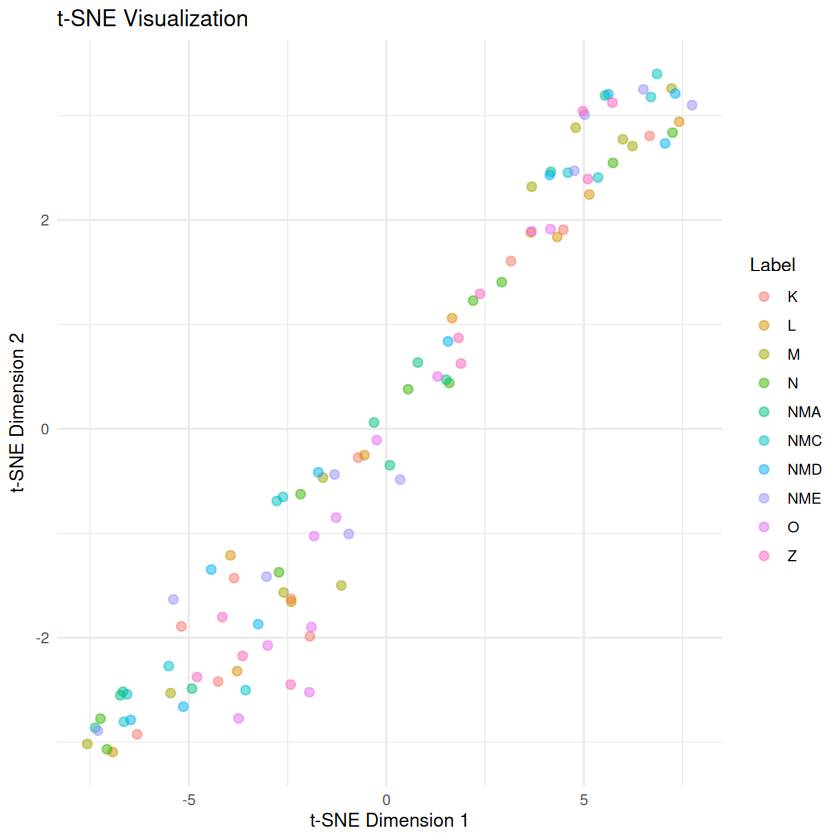

In [64]:
set.seed(42)
tsne_result <- Rtsne(latent_data, dims = 2, perplexity = 30, verbose = TRUE)

latent_df <- data.frame(
  X = tsne_result$Y[, 1],
  Y = tsne_result$Y[, 2]
)

latent_df$Label <- df_12_5$Individual
ggplot(latent_df, aes(x = X, y = Y, color = Label)) +
    geom_point(alpha = 0.5, size = 2) +
    labs(title = "t-SNE Visualization",
         x = "t-SNE Dimension 1",
         y = "t-SNE Dimension 2") +
    theme_minimal()




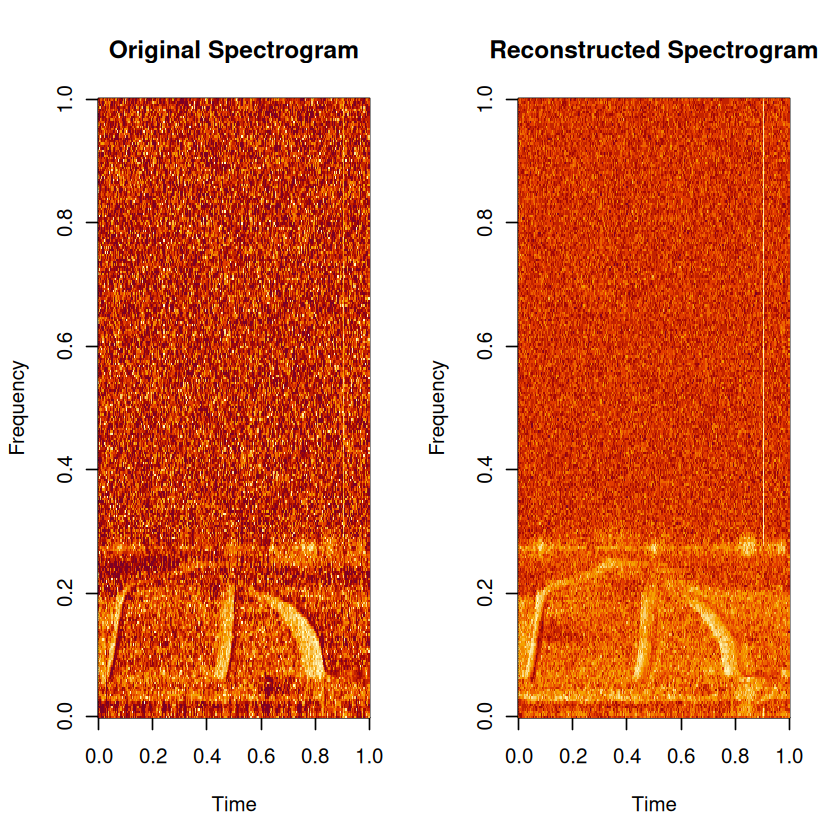

In [65]:
reconstructed_data <- keras:::predict.keras.engine.training.Model(autoencoder, spectrogram_matrix)

time_bins <- time_bins
freq_bins <- freq_bins

original_sample <- matrix(spectrogram_matrix[60, ], nrow = freq_bins, ncol = time_bins)
reconstructed_sample <- matrix(reconstructed_data[60, ], nrow = freq_bins, ncol = time_bins)

par(mfrow = c(1, 2))
image(t(original_sample), main = "Original Spectrogram", xlab = "Time", ylab = "Frequency")
image(t(reconstructed_sample), main = "Reconstructed Spectrogram", xlab = "Time", ylab = "Frequency")


## Creating dataframes for different distances

### 12-5

In [25]:
audio_list_12_5 = load_wav_files(path = "./data/Propagation_experiments/individuals_propagation/12_5_m/")


[1] "./data/Propagation_experiments/individuals_propagation/12_5_m//K_segment_11_12-5m.wav"
[1] "./data/Propagation_experiments/individuals_propagation/12_5_m//K_segment_12_12-5m.wav"
[1] "./data/Propagation_experiments/individuals_propagation/12_5_m//K_segment_13_12-5m.wav"
[1] "./data/Propagation_experiments/individuals_propagation/12_5_m//K_segment_14_12-5m.wav"
[1] "./data/Propagation_experiments/individuals_propagation/12_5_m//K_segment_15_12-5m.wav"
[1] "./data/Propagation_experiments/individuals_propagation/12_5_m//K_segment_16_12-5m.wav"
[1] "./data/Propagation_experiments/individuals_propagation/12_5_m//K_segment_17_12-5m.wav"
[1] "./data/Propagation_experiments/individuals_propagation/12_5_m//K_segment_18_12-5m.wav"
[1] "./data/Propagation_experiments/individuals_propagation/12_5_m//K_segment_19_12-5m.wav"
[1] "./data/Propagation_experiments/individuals_propagation/12_5_m//K_segment_20_12-5m.wav"
[1] "./data/Propagation_experiments/individuals_propagation/12_5_m//L_segment_21

In [26]:
df_12_5 <- process_audio_list(audio_list_12_5)


In [27]:
saveRDS(df_12_5, "./data/Propagation_experiments/df_12_5.rds")


In [35]:
df_12_5 <- readRDS("./data/Propagation_experiments/df_12_5.rds")


In [28]:
spec_features_12_5 <- as.matrix(df_12_5[, 1:(ncol(df_12_5) - 2)])
pca_12_5 <- prcomp(spec_features_12_5, center = TRUE, scale. = TRUE)

summary(pca_12_5)


Importance of components:
                           PC1      PC2      PC3     PC4      PC5      PC6
Standard deviation     105.448 51.86605 33.66268 29.5385 27.98341 26.16342
Proportion of Variance   0.181  0.04378  0.01844  0.0142  0.01275  0.01114
Cumulative Proportion    0.181  0.22476  0.24321  0.2574  0.27015  0.28129
                            PC7      PC8      PC9     PC10    PC11    PC12
Standard deviation     25.02192 24.69557 24.29734 24.04927 23.7750 23.6447
Proportion of Variance  0.01019  0.00993  0.00961  0.00941  0.0092  0.0091
Cumulative Proportion   0.29148  0.30141  0.31102  0.32043  0.3296  0.3387
                           PC13     PC14     PC15    PC16     PC17    PC18
Standard deviation     23.41145 23.16447 23.09609 22.9818 22.84433 22.7199
Proportion of Variance  0.00892  0.00873  0.00868  0.0086  0.00849  0.0084
Cumulative Proportion   0.34765  0.35639  0.36507  0.3737  0.38216  0.3906
                           PC19     PC20     PC21     PC22     PC23     PC

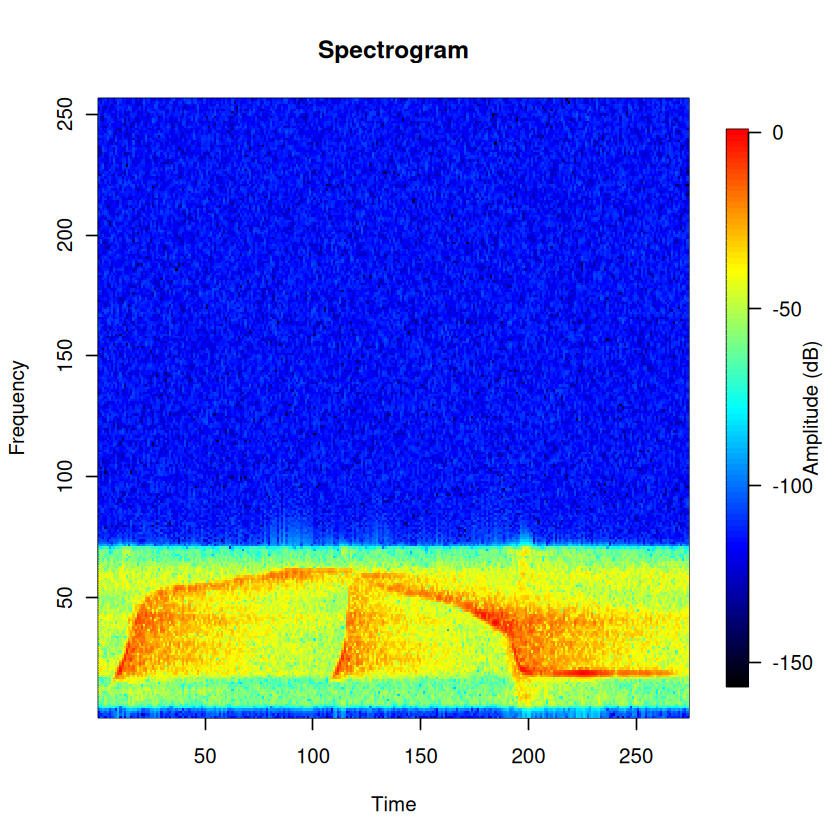

In [ ]:
spectrogram <- df_12_5[1, ]

spec_features <- spectrogram[1:(ncol(spectrogram) - 2)]

plot_spectro(spec_features)


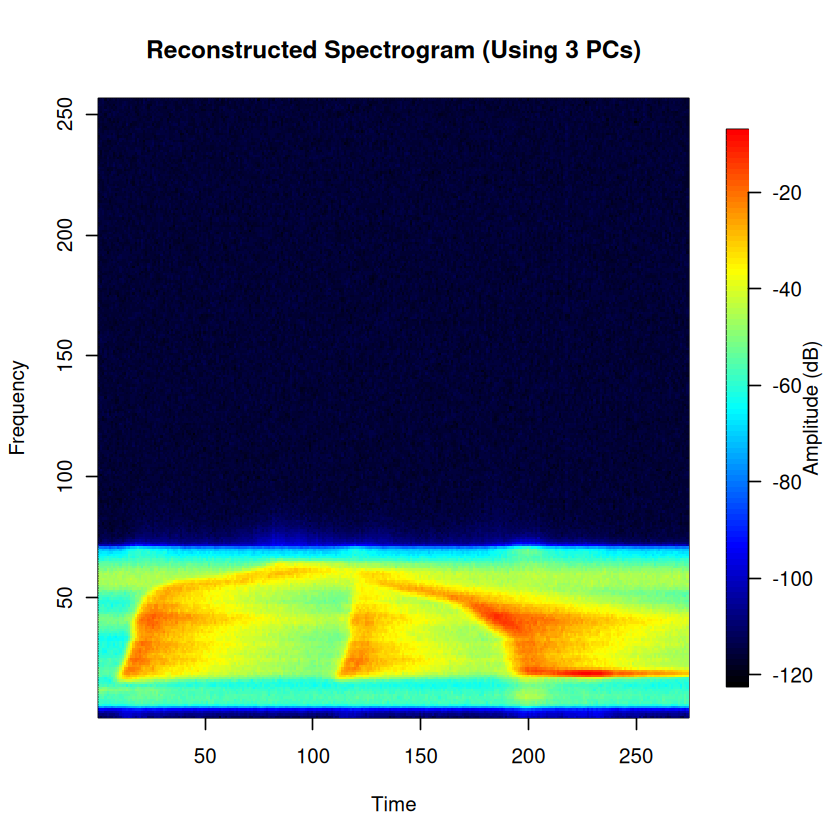

In [ ]:
num_components <- 3
pca_components <- pca_12_5$rotation
pca_scores <- pca_12_5$x

reconstructed_features <- pca_scores[, 1:num_components] %*% t(pca_components[, 1:num_components])

# Reverse scaling and centering
if (!is.null(pca_12_5$scale)) {
  reconstructed_features <- scale(reconstructed_features, center = FALSE, scale = 1 / pca_12_5$scale)
}
if (!is.null(pca_12_5$center)) {
  reconstructed_features <- scale(reconstructed_features, center = -pca_12_5$center, scale = FALSE)
}

plot_reconstructed_spectro(reconstructed_features, num_components)


In [29]:
explained_variance <- cumsum(pca_12_5$sdev^2 / sum(pca_12_5$sdev^2))
num_components <- which.max(explained_variance >= 0.99999)

num_components

pca_data <- pca_12_5$x[, 1:num_components]

pca_df <- as.data.frame(pca_data)
pca_df$Individual <- df_12_5$Individual
pca_df$Distance <- df_12_5$Distance

saveRDS(pca_df, file = "./data/Propagation_experiments/df_pca_12_5.rds")



[1] 99